In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [127]:
import os
import cv2
import numpy as np
from tqdm import tqdm
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import BatchNormalization
from keras.layers import Input, Lambda, Dense, Flatten, Activation, Dropout
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import RMSprop
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras import applications

In [144]:
# gives the list of all directories and subdirectories
train = list(os.walk('/kaggle/input/animals/animals/train')) 

In [158]:
label_names = train[0][1]
print(label_names)
dict_labels = dict(zip(label_names, list(range(len(label_names)))))
print(dict_labels)

['horse', 'lion', 'dog', 'elephant', 'cat']
{'horse': 0, 'lion': 1, 'dog': 2, 'elephant': 3, 'cat': 4}


In [146]:
def dataset(path): # put path till the highest directory level
    images = []
    labels = []
    for folder in tqdm(os.listdir(path)):
    
# dict_labels is the dictionary whose key:value pairs are classes:numbers 
# representing them
        value_of_label = dict_labels[folder] 

        for file in (os.listdir(os.path.join(path, folder))):
            path_of_file = os.path.join(os.path.join(path, folder), file)

            image = cv2.imread(path_of_file)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = cv2.resize(image, (150, 150))
            images.append(image)
            labels.append(value_of_label)

    images = np.array(images, dtype = 'float32')/255.0
    labels = np.array(labels)

    return images, labels

images, labels = dataset('/kaggle/input/animals/animals/train')
images, labels = shuffle(images, labels)

100%|██████████| 5/5 [00:56<00:00, 11.24s/it]


In [147]:
images.shape

(13474, 150, 150, 3)

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


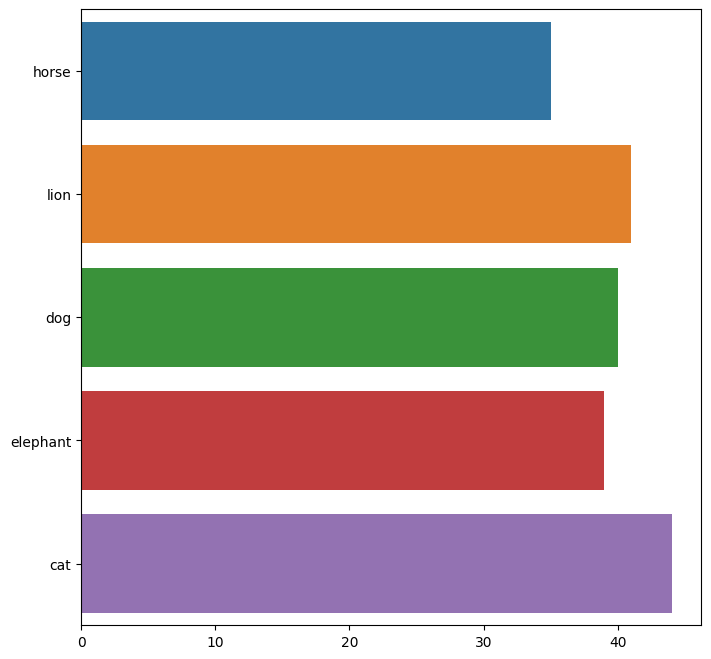

In [148]:
animals = train[0][1]
no_of_animals = []
for _ in range(0, 5):
    no_of_animals.append(len(train[_][0]))
plt.figure(figsize = (8, 8))
sns.barplot(y = animals, x = no_of_animals);

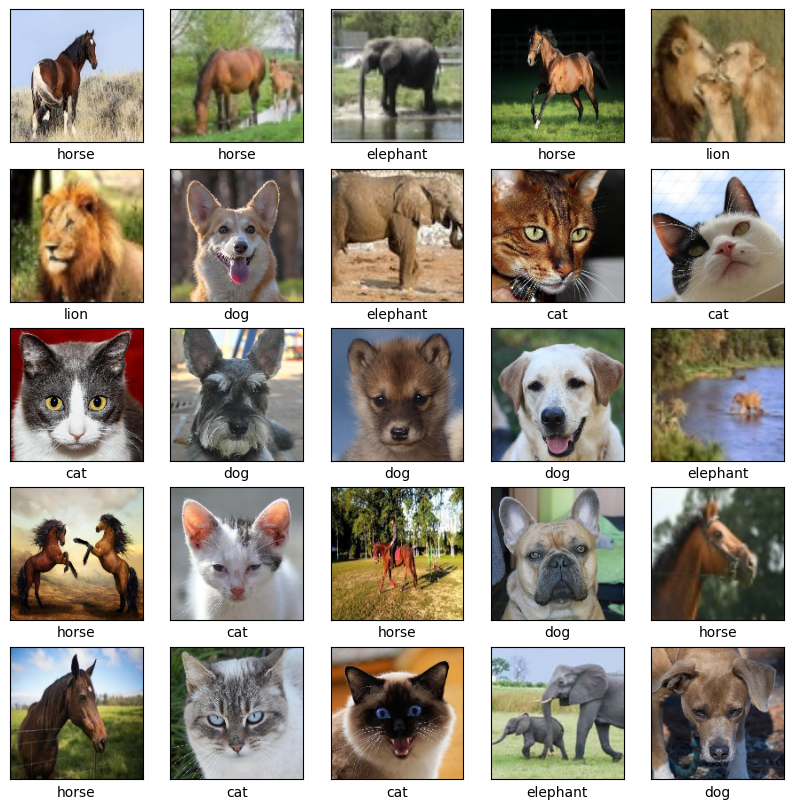

In [149]:
plt.figure(figsize = (10,10))
for _ in range(25):
    plt.subplot(5, 5, _+1)
    plt.yticks([])
    plt.xticks([])
    plt.grid(False)
    data = images[_]
    plt.xlabel(label_names[labels[_]])
    plt.imshow(data);

In [150]:
batch_size = 4 # Number of samples that will be processed in each iteration during training.

train_datagen = ImageDataGenerator(
    rescale = 1./255,  # Normalizes pixel values to the range of 0 to 1.
     shear_range = 0.1, # Randomly applies shearing transformations to images.
     zoom_range = 0.1,  # Randomly zooms in or out of images.
     horizontal_flip = True,  # Randomly flips images horizontally.
     width_shift_range = 0.1, # Randomly shifts images horizontally.
     height_shift_range = 0.1 # Randomly shifts images vertically.
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    '/kaggle/input/animals/animals/train',
    target_size = (224,224),
    batch_size = batch_size,
    class_mode = 'categorical'
)

test_generator = test_datagen.flow_from_directory(
    '/kaggle/input/animals/animals/val',
    target_size = (224,224),
    batch_size = batch_size,
    class_mode = 'categorical'
)

Found 13474 images belonging to 5 classes.
Found 1497 images belonging to 5 classes.


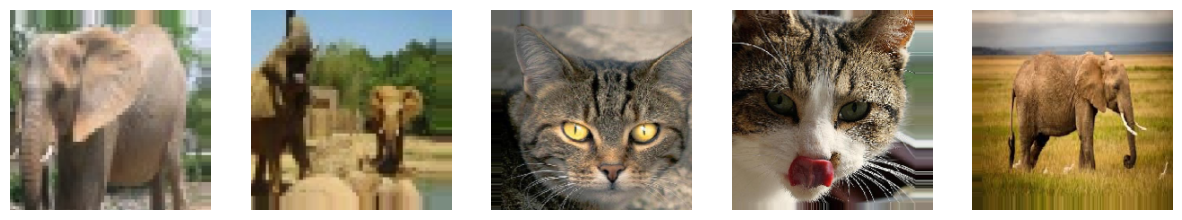

In [151]:
fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(15,15))

for i in range(5):
    image = next(train_generator)[0][0]
    image = np.squeeze(image)
    ax[i].imshow(image)
    ax[i].axis(False)

In [152]:
from keras.applications.vgg16 import VGG16
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.layers import Dense,Conv2D,MaxPooling2D,Flatten,BatchNormalization,Dropout

In [153]:
conv_base = VGG16(
    weights = 'imagenet',
    include_top = False, # Not including the Dense Layer
    input_shape = (224,224,3)
)

In [154]:
conv_base.trainable = False

In [164]:
pretrained_model = tf.keras.applications.Xception(weights='imagenet', include_top=False, input_shape=[224,224, 3])
pretrained_model.trainable=False
vgg16_model = tf.keras.Sequential([
    pretrained_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(5, activation='softmax')
])

In [155]:
model = Sequential()

model.add(conv_base)
model.add(Flatten())
model.add(Dense(256,activation='relu'))
model.add(Dropout(0.1))

model.add(Dense(120,activation='relu'))
model.add(Dropout(0.1))

model.add(Dense(32,activation='relu'))
model.add(Dropout(0.1))

model.add(Dense(5,activation='softmax'))
model.summary()

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 25088)             0         
                                                                 
 dense_25 (Dense)            (None, 256)               6422784   
                                                                 
 dropout_3 (Dropout)         (None, 256)               0         
                                                                 
 dense_26 (Dense)            (None, 120)               30840     
                                                                 
 dropout_4 (Dropout)         (None, 120)               0         
                                                                 
 dense_27 (Dense)            (None, 32)              

In [165]:
vgg16_model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [166]:
batch_size=32

In [177]:
history = vgg16_model.fit(train_generator,epochs=50,steps_per_epoch=len(train_generator)/batch_size,
                    validation_steps = len(test_generator)/batch_size,
                    validation_data=test_generator)

Epoch 1/50
105/105 [==============================] - 6s 58ms/step - loss: 0.0967 - accuracy: 0.9693 - val_loss: 0.0712 - val_accuracy: 0.9792
Epoch 2/50
105/105 [==============================] - 6s 55ms/step - loss: 0.0786 - accuracy: 0.9764 - val_loss: 0.1205 - val_accuracy: 0.9792
Epoch 3/50
105/105 [==============================] - 6s 53ms/step - loss: 0.1092 - accuracy: 0.9646 - val_loss: 0.0159 - val_accuracy: 1.0000
Epoch 4/50
105/105 [==============================] - 6s 60ms/step - loss: 0.1138 - accuracy: 0.9623 - val_loss: 0.1402 - val_accuracy: 0.9583
Epoch 5/50
105/105 [==============================] - 6s 57ms/step - loss: 0.0453 - accuracy: 0.9764 - val_loss: 0.1206 - val_accuracy: 0.9375
Epoch 6/50
105/105 [==============================] - 6s 59ms/step - loss: 0.0630 - accuracy: 0.9764 - val_loss: 0.0968 - val_accuracy: 0.9792
Epoch 7/50
105/105 [==============================] - 6s 54ms/step - loss: 0.1373 - accuracy: 0.9552 - val_loss: 0.1786 - val_accuracy: 0.9167

In [178]:
model.save('vgg16_modelv2.h5')

In [169]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image

In [170]:
train_generator.class_indices

{'cat': 0, 'dog': 1, 'elephant': 2, 'horse': 3, 'lion': 4}

In [171]:
def predictor(img, model):
    image = cv2.imread(img)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (224, 224))
    image = np.array(image, dtype = 'float32')/255.0
    plt.imshow(image)
    image = image.reshape(1, 224,224,3)
    
    label_names = train_generator.class_indices
    dict_class = dict(zip(list(range(len(label_names))), label_names))
    clas = model.predict(image).argmax()
    name = dict_class[clas]
    print('The given image is of \nClass: {0} \nAnimal: {1}'.format(clas, name))

1/1 [==============================] - 0s 21ms/step
The given image is of 
Class: 2 
Animal: elephant


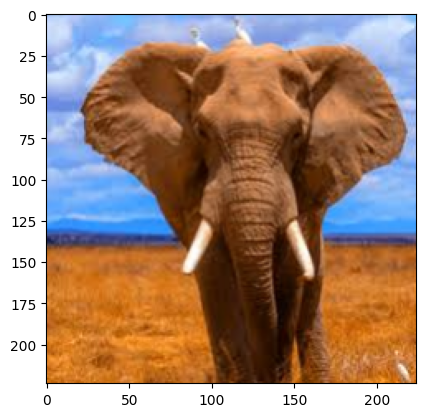

In [180]:
predictor("/kaggle/input/animals/animals/inf/elephant.jpg", vgg16_model)

1/1 [==============================] - 0s 151ms/step
[1]


Text(0.5, 1.0, 'dog')

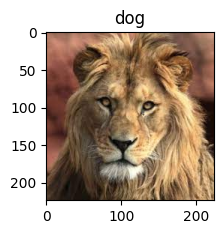

In [123]:
model = load_model("/kaggle/working/vgg16_modelv1.h5")
img = image.load_img("/kaggle/input/animals/animals/inf/lion.jpg", target_size=(224,224))
img_arr = image.img_to_array(img)
img_arr = np.expand_dims(img_arr, axis=0)
pred = np.argmax(model.predict(img_arr), axis=1)
print(pred)

plt.subplot(221)
plt.imshow(img)
plt.title(class_names[int(pred)])